In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

from dotenv import load_dotenv, find_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

import pickle
load_dotenv(find_dotenv())

COMET_API_KEY = os.environ.get("COMET_API_KEY")

import sys
sys.path.append('/Users/iamyash/Desktop/NHL-DataScience-lIFT-6758')  # Add the root project directory path


from src.utils.result_plot_utils import plot_calibration_multi, plot_cumu_goal_multi, plot_goal_ratio_multi, plot_roc_multi

In [2]:
df = pd.read_csv("./../../data/FE1/20162019_clean 4.csv")
df.head(2)

,gamePk,season,gameType,home,away,eventTypeId,shotType,shooter,shooterTeam,distance,angle,goalie,eventPeriod,eventPeriodType,x,y,emptyNet,isGoal
0,2016020001,20162017,R,Ottawa Senators,Toronto Maple Leafs,HIT,NaN,NaN,NaN,NaN,NaN,NaN,3,REGULAR,-51.0,35.0,0,0
1,2016020001,20162017,R,Ottawa Senators,Toronto Maple Leafs,FACEOFF,NaN,NaN,NaN,NaN,NaN,NaN,2,REGULAR,69.0,22.0,0,0


In [3]:
df.shotType.unique()

array([nan, 'Wrist Shot', 'Snap Shot', 'Slap Shot', 'Tip-In', 'Backhand',
       'Deflected', 'Wrap-around'], dtype=object)

In [4]:
df.shotType.isna().sum()

1361282

In [5]:
cleaned_df = df[(~df.distance.isna())]
cleaned_df =  cleaned_df[cleaned_df['distance']!='shoot out']

In [6]:
cleaned_df.season.unique()

array([20162017, 20172018, 20182019, 20192020])

## Train and Validation split

- Here, we will use season `{20162017, 20172018, 20182019}` in training and `{20192020}` for validation.

In [7]:
train_seasons = [20162017, 20172018, 20182019]
train_df = cleaned_df[cleaned_df.season.isin(train_seasons)]
val_df = cleaned_df[~cleaned_df.season.isin(train_seasons)]
print(cleaned_df.shape, train_df.shape, val_df.shape)

(315818, 18) (245555, 18) (70263, 18)


In [8]:
def plot_roc_curve(model, X_val, y_val,title, experiment=None):
    
    fpr, tpr, thresholds = roc_curve( y_val, model.predict_proba(X_val)[:,1] )
    
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2,label='random baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [9]:
def run_experiment(name, model, X_train, y_train, X_test, y_test, ckpt_path="./../../models/"):
    experiment = Experiment(
      api_key=COMET_API_KEY,
      project_name="baselines",
      workspace="ift6758-milestone2-udem"
    )
    
    model.fit(X_train,y_train)
    file_name = name + '.pkl'
    with open(os.path.join(ckpt_path, file_name), 'wb') as file:  
        pickle.dump(model, file)    
    y_pred = model.predict(X_test)
    
    test_acc = metrics.accuracy_score(y_test, y_pred)
    print(f"Test accuracy :{test_acc}")
    plot_roc_curve(model, X_test, y_test,title=f"AUROC: {name}", experiment=experiment)
    
    
    experiment.log_metric("Test accuracy", test_acc)
    experiment.log_model(name, os.path.join(ckpt_path, file_name))
    experiment.end()

In [10]:
val_df.isGoal.value_counts()

isGoal
0    63626
1     6637
Name: count, dtype: int64

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/420efb3e054748d1bc2b9a5ae1448d09



Test accuracy :0.9055406117017492


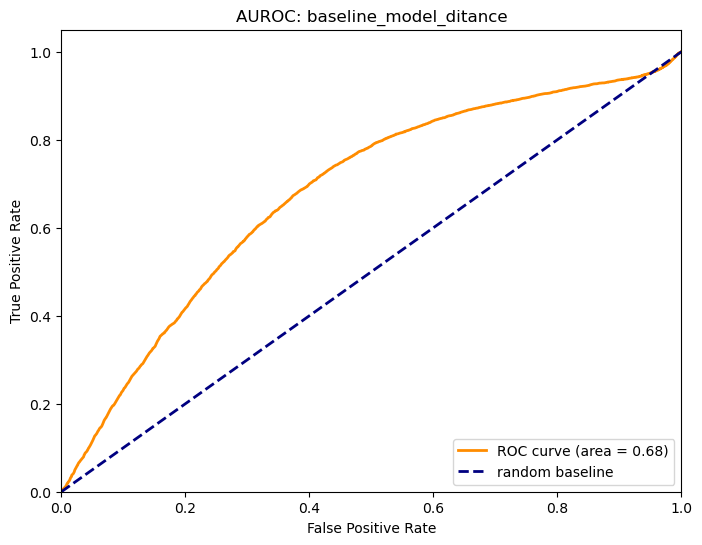

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/420efb3e054748d1bc2b9a5ae1448d09
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.9055406117017492
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : None
COMET INFO:     penalty           : l2
COMET INFO:     random_state      : None
COMET INFO:     solver  

In [11]:
X_train = train_df[['distance']]
y_train = train_df[['isGoal']]

X_val = val_df[['distance']]
y_val = val_df[['isGoal']]


model = LogisticRegression()

run_experiment("baseline_model_ditance", model, X_train, y_train, X_val, y_val, )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/bf85b186847e4b12954e293a90625ff8



Test accuracy :0.9055406117017492


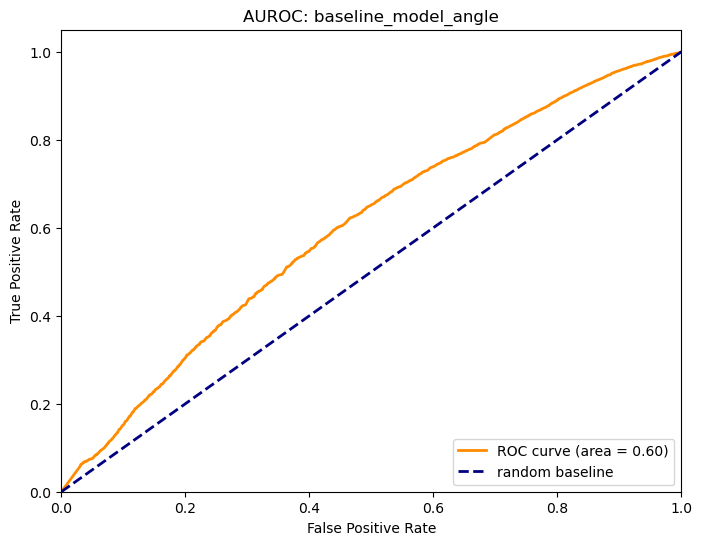

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/bf85b186847e4b12954e293a90625ff8
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.9055406117017492
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : None
COMET INFO:     penalty           : l2
COMET INFO:     random_state      : None
COMET INFO:     solver  

In [12]:
X_train = train_df[['angle']]
y_train = train_df[['isGoal']]

X_val = val_df[['angle']]
y_val = val_df[['isGoal']]

model = LogisticRegression()

run_experiment("baseline_model_angle", model, X_train, y_train, X_val, y_val, )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/247d43e9e65d4c0dbd39afc22d19bab1



Test accuracy :0.9055406117017492


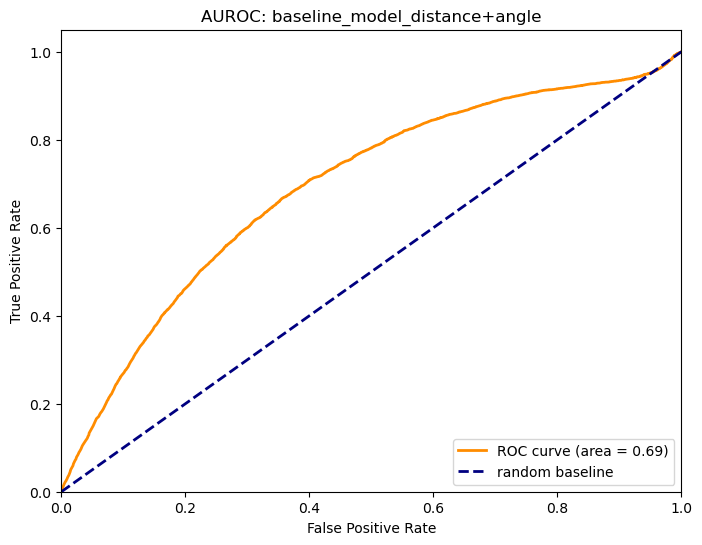

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/247d43e9e65d4c0dbd39afc22d19bab1
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.9055406117017492
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : None
COMET INFO:     penalty           : l2
COMET INFO:     random_state      : None
COMET INFO:     solver  

In [13]:
X_train = train_df[['distance', 'angle']]
y_train = train_df[['isGoal']]

X_val = val_df[['distance', 'angle']]
y_val = val_df[['isGoal']]

model = LogisticRegression()

run_experiment("baseline_model_distance+angle", model, X_train, y_train, X_val, y_val, )

## Ploting the predictions visualization curves
- ROC/AUC
- Goal rate vs probability percentile
- Cumulative proportion of goals vs probability percentile
- Reliability curve


In [14]:
########### Model with 'Distance' as feature
X_train = train_df[['distance']]
y_train = train_df[['isGoal']]
X_val = val_df[['distance']]
y_val = val_df[['isGoal']]

model1 = LogisticRegression()
model1.fit(X_train,y_train)

y_prob1 = model1.predict_proba(X_val)

########### Model with 'Angle' as feature
X_train = train_df[[ 'angle']]
y_train = train_df[['isGoal']]
X_val = val_df[[ 'angle']]
y_val = val_df[['isGoal']]

model2 = LogisticRegression()
model2.fit(X_train,y_train)

y_prob2 = model2.predict_proba(X_val)

########### Model with 'Distace' and 'Angle' as feeatures
X_train = train_df[['distance', 'angle']]
y_train = train_df[['isGoal']]

X_val = val_df[['distance', 'angle']]
y_val = val_df[['isGoal']]

model3 = LogisticRegression()
model3.fit(X_train,y_train)

y_prob3 = model3.predict_proba(X_val)

########### Random Baseline

y_random = np.random.uniform(0, 1, size=len(y_val))

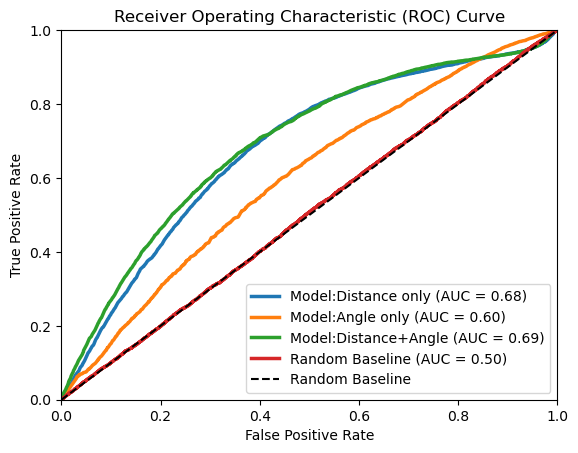

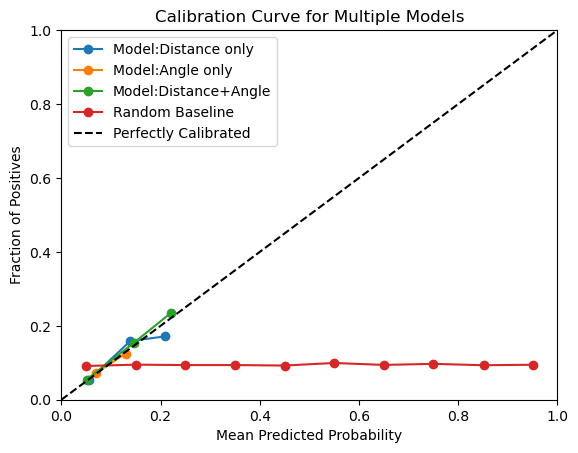

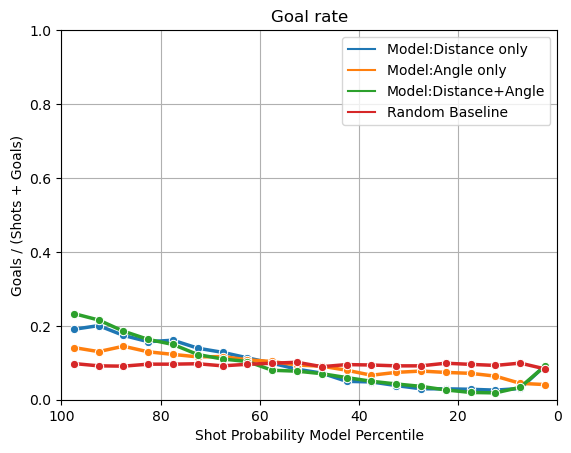

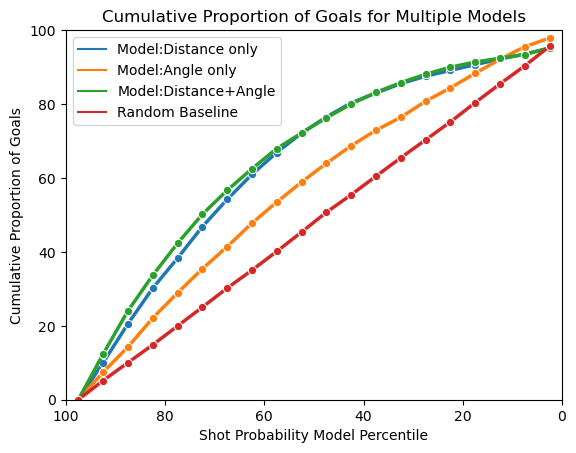

In [15]:
models = [('Model:Distance only', y_prob1[:, 1]), ('Model:Angle only', y_prob2[:, 1]), ('Model:Distance+Angle', y_prob3[:, 1]), ('Random Baseline', y_random)]

plot_roc_multi(models, y_val)
plot_calibration_multi(models, y_val)
plot_goal_ratio_multi(models, y_val.values.reshape(-1))
plot_cumu_goal_multi(models, y_val.values.reshape(-1))
